## Feature engineering

На данном этапе оценю важность признаков и их кол-во.
Для понимания достаточно ли у нас признаков или наобор их много - использую жадный алгоритм для feature selection:

In [1]:
# Стандартная библиотека
import sys
sys.path.insert(0, '/home/alorozhkov/jup/ml_projects/Marketing_Response/utils/')
sys.path.insert(0, '/home/alorozhkov/jup/ml_projects/Marketing_Response/src/')

import os
from getpass import getpass

import time
from tqdm import tqdm


import numpy as np
np.random.seed(42)


import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = lambda x: ('%.12f' % x).rstrip('0').rstrip('.')

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rcParams['font.family'] = 'DejaVu Sans'


#MLFlow
import mlflow
mlflow.set_tracking_uri(f'http://127.0.0.1:5000/')
mlflow.set_experiment("Marketing_Response")
mlflow.sklearn.autolog(disable=True)

#AutoML
from pycaret.classification import *


#Стат тесты
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Нормализация и балансировка данных
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Подбор гиперпарамметров
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split
)


#Обучение модели
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

#Метрики
from sklearn.metrics import (
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, roc_auc_score,
    PrecisionRecallDisplay, RocCurveDisplay
)

# Отбор признаков
from sklearn.feature_selection import SelectKBest, f_classif
import shap


# Импорт вспомогательных функций
from data_preprocessing import split_and_scale, check_distribution
from train_log_funcs import *
from visualisation import (
    compare_all_numerical_features,
    compare_all_categorical_features
)

In [2]:
#Путь к данным
processed_data = '/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_DATA.csv'
processed_automl = '/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_EDA_DATA.csv'

In [3]:
#Загрузка данных
df_model = pd.read_csv('/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_EDA_DATA.csv')
df_model.head(2)

,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,HigherEducation,IsHighIncome,IncomeLog,TotalSpentLog,AcceptedAnyCmp
0,58,7,1,68,0,0,1,0,10.970591974103,7.388946097618,0
1,38,5,0,71,1,0,1,0,10.74386869031,3.332204510175,0


In [4]:
# Данные для X:
feature_columns = ['Recency', 'NumWebVisitsMonth', 'Age', 'HasChildren','MaritalFlag', 'HigherEducation', 'IsHighIncome', 'AcceptedAnyCmp', 'TotalSpentLog','IncomeLog']
num_cols = ['Recency', 'NumWebVisitsMonth', 'Age', 'TotalSpentLog']

In [5]:
#  Делим признаки и целевой столбец
X = df_model[feature_columns]
y = df_model['Response'] 

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale(
    df_model,
    target_col='Response',
    feature_cols=feature_columns,
    num_cols=num_cols
)

Размер выборок:
  Train: (1405, 10), y_train: (1405,)
  Val:   (301, 10), y_val:   (301,)
  Test:  (302, 10), y_test:  (302,)


Кол-во оставшихся фичей для проверки: 10


100%|█████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


Кол-во оставшихся фичей для проверки: 9


100%|███████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.82it/s]


Кол-во оставшихся фичей для проверки: 8


100%|███████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.36it/s]


Кол-во оставшихся фичей для проверки: 7


100%|███████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


Кол-во оставшихся фичей для проверки: 6


100%|███████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


Кол-во оставшихся фичей для проверки: 5


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


Кол-во оставшихся фичей для проверки: 4


100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s]


Кол-во оставшихся фичей для проверки: 3


100%|███████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Кол-во оставшихся фичей для проверки: 2


100%|███████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


Кол-во оставшихся фичей для проверки: 1


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


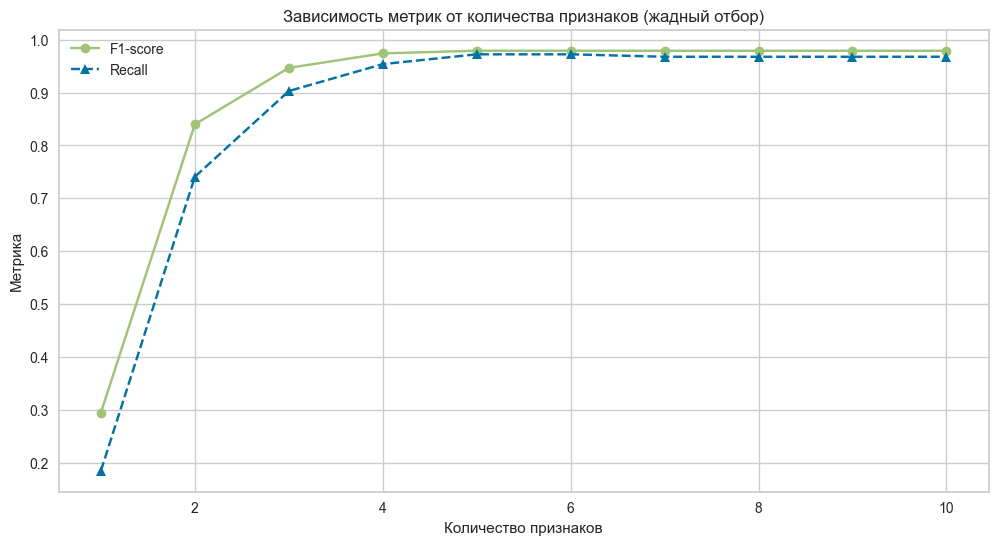

In [7]:
# Используем только обучающую выборку
X = X_train.copy()
y = y_train.copy()

selected_features = []
remaining_features = list(X.columns)

best_f1 = 0
f1_values = []
recall_values = []
num_features = []

# Жадный отбор признаков
for _ in range(len(remaining_features)):
    print(f"Кол-во оставшихся фичей для проверки: {len(remaining_features)}")
    best_feature = None
    best_local_f1 = 0
    best_local_recall = 0

    for feature in tqdm(remaining_features):
        temp_features = selected_features + [feature]
        X_subset = X[temp_features]

        model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=False)
        model.fit(X_subset, y)

        y_pred = model.predict(X_subset)
        f1 = f1_score(y, y_pred)
        recall = recall_score(y, y_pred)

        if f1 > best_local_f1:
            best_local_f1 = f1
            best_local_recall = recall
            best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_f1 = best_local_f1

        f1_values.append(best_f1)
        recall_values.append(best_local_recall)
        num_features.append(len(selected_features))

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(num_features, f1_values, label="F1-score", marker='o', linestyle='-', color='g')
plt.plot(num_features, recall_values, label="Recall", marker='^', linestyle='--', color='b')
plt.xlabel("Количество признаков")
plt.ylabel("Метрика")
plt.title("Зависимость метрик от количества признаков (жадный отбор)")
plt.legend()
plt.grid(True)
plt.show()

Вывод:

Оптимальное кол-во признаков - 4-5, так как обе метрики достигают здесь максимума

Выведем важность признаков по этим двум метрикам:

In [8]:
# Создаём DataFrame с порядком отбора признаков и их метриками
feature_selection_order = pd.DataFrame({
    'Feature': selected_features,
    'recall': recall_values,
    'f1': f1_values
})

# Добавляем столбец с порядковым номером отбора
feature_selection_order['Selection_Order'] = range(1, len(selected_features)+1)

# Сортируем по F1-score (по убыванию) для наглядности
feature_selection_order = feature_selection_order.sort_values('f1', ascending=False)

# Форматируем вывод чисел
pd.options.display.float_format = '{:.3f}'.format

# Отображаем DataFrame с подсветкой максимальных значений
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

display(feature_selection_order.style.apply(highlight_max, subset=['recall', 'f1']))

,Feature,recall,f1,Selection_Order
4,MaritalFlag,0.972222,0.979021,5
5,IsHighIncome,0.972222,0.979021,6
8,HasChildren,0.967593,0.978923,9
9,HigherEducation,0.967593,0.978923,10
7,AcceptedAnyCmp,0.967593,0.978923,8
6,Age,0.967593,0.978923,7
3,NumWebVisitsMonth,0.953704,0.973995,4
2,IncomeLog,0.902778,0.946602,3
1,Recency,0.740741,0.839895,2
0,TotalSpentLog,0.185185,0.295203,1


Для проверки важности признаков использую SHAP который показывает вклад каждого признака в предсказание

Данный инструмент поможет прояснить  следующие моменты:
- Какие признаки влияют на предсказание модели
- В какую сторону — увеличивают или уменьшают вероятность положительного класса
- Какие признаки малоинформативны или шумовые

 97%|=================== | 1356/1405 [00:25<00:00]       

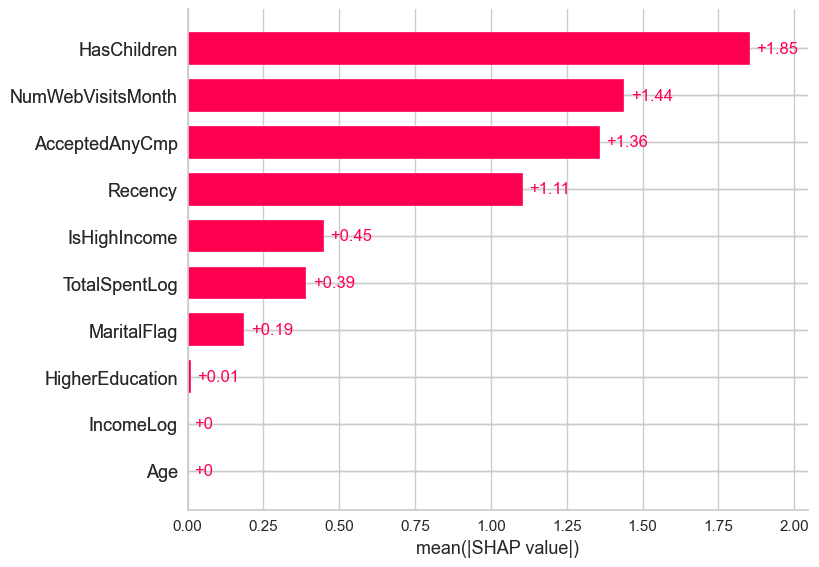

In [9]:
# Выбираем explainer 
explainer = shap.Explainer(model, X_train)

# Считаем shap values
shap_values = explainer(X_train)

# Глобальная важность признаков
shap.plots.bar(shap_values)

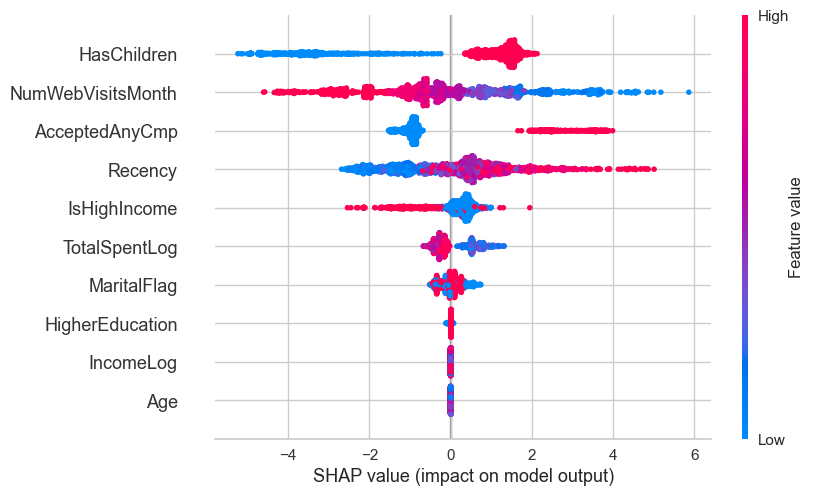

In [10]:
shap.plots.beeswarm(shap_values)

Обязательные к включению (сильная важность по SHAP и хорошие метрики в жадном алгоритме):
- HasChildren — самый важный по SHAP и достаточно высокое качество модели при его использовании.
- NumWebVisitsMonth — тоже очень важный по SHAP и имеет хорошее качество.
- AcceptedAnyCmp — важен и для SHAP, и для метрик.

Признаки с низкой важностью и плохими метриками:
- Recency — низкие recall и F1, хотя SHAP и показывает среднюю важность.
- TotalSpentLog — низкие метрики и низкая важность по SHAP.